In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from pyvis.network import Network
import stylecloud

from IPython.display import Image, display

import re
from nltk.util import ngrams
from nltk.collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

def plot_conversation_network(from_to_data = from_to_counts, edge_divider = 125,
                              k = 6, size = (16, 9), node_size_power = 0.85):
    
    np.random.seed(12)
    nodes = from_to_data.groupby('speaker')['weight'].sum()

    G = nx.from_pandas_edgelist(from_to_data, source = 'speaker', target = 'speaking_to', 
                                edge_attr = 'weight', create_using = nx.Graph())

    node_sizes = nodes[[i for i in G.nodes]]

    line_widths = [i['weight'] / edge_divider for i in dict(G.edges).values()]
    labels = {i:i for i in dict(G.nodes).keys()}

    plt.figure(figsize = size) 

    pos = nx.fruchterman_reingold_layout(G, k = k)
    nx.draw_networkx_nodes(G, pos = pos, node_size = np.power(node_sizes, node_size_power), 
                           node_color = 'lightgray', edgecolors = 'gray', alpha = 1) 
    nx.draw_networkx_edges(G, pos = pos, width = line_widths, edge_color = 'black', alpha = 1/2)
    nx.draw_networkx_labels(G, pos = pos, font_size = 11)

    plt.box(False)
    plt.show()
    
# good styles:
# 1. fruchterman_reingold_layout
# 2. circular_layout
# 3. spring_layout


def ngram_plots(ngram_number = 1, row_spacing = .03, col_spacing = .1, width = 950, col_wrap = 3):
    
    ngram_col_name = 'ngram_' + str(ngram_number)
    
    fig = px.bar(grams_dfs_N[ngram_number].groupby('speaker').head(10).sort_values(['speaker', 'count']), 'count', ngram_col_name, facet_col='speaker', 
             facet_col_wrap=col_wrap, facet_row_spacing=row_spacing, facet_col_spacing=col_spacing,
              title = 'Top ngrams (' + str(ngram_number) + ') by characters',
              labels = {ngram_col_name : ''}, width = width, height = 1650)
    fig.update_xaxes(showticklabels = True, matches = None)
    fig.update_yaxes(showticklabels=True, matches = None, tickfont = {'size' : 10})
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_layout(showlegend = False)
    fig.show()
    
    
def plot_tfidf_data(data = tfidf_data, row_spacing = .03, col_spacing = .1, width = 950, col_wrap = 3):
    
    fig = px.bar(data, 'score', 'word', facet_col='speaker', 
             facet_col_wrap=col_wrap, facet_row_spacing=row_spacing, facet_col_spacing=col_spacing,
              title = 'Top characters most personal words (TF-IDF)',
              labels = {'score' : 'Tf-Idf value', 'word' : ''}, width = width, height = 1650)
    fig.update_xaxes(showticklabels = True, matches = None)
    fig.update_yaxes(showticklabels=True, matches = None, tickfont = {'size' : 10})
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_layout(showlegend = False)
    fig.show()

In [4]:
data = pd.read_csv('../../data/transcripts_cleaned.csv')
data.head(3)

season  episode  title  scene  speaker  \
0       1        1  Pilot      1  Michael   
1       1        1  Pilot      1      Jim   
2       1        1  Pilot      1  Michael   

                                                line  \
0  All right Jim. Your quarterlies look very good...   
1         Oh, I told you. I couldn't close it. So...   
2  So you've come to the master for guidance? Is ...   

                                             cleaned  \
0  all right jim your quarterlies look very good ...   
1              oh i told you i could not close it so   
2  so you have come to the master for guidance is...   

                                   cleaned_sw_rem  
0  right jim quarterlies look good things library  
1                                      told close  
2              master guidance saying grasshopper

### Line count

In [5]:
top_lines = data['speaker'].value_counts().head(23)
top_characters = top_lines.index

In [6]:
med_line_count = data[data['speaker'].isin(top_characters)].groupby(['speaker', 'season']).agg({'line' : 'count'}).reset_index().groupby('speaker').agg({'line' : 'median'}).reset_index().rename(columns = {'line' : 'median_lines_by_season'})
med_line_count.loc[med_line_count['speaker'] == 'Robert California', 'median_lines_by_season'] = 394
med_line_count.set_index('speaker', inplace = True)

In [7]:
line_count_data = pd.concat([top_lines, med_line_count], 1).reset_index().rename(columns = {'speaker' : 'total_lines', 'index' : 'speaker'})

In [8]:
line_count_by_season = data[data['speaker'].isin(top_characters)].pivot_table(index = 'speaker', columns = ['season'], values = 'line', aggfunc = 'count')
line_count_by_season = line_count_by_season.fillna(0).astype(int).reset_index()

In [9]:
line_count_by_season_all = data.pivot_table(index = 'speaker', columns = ['season'], values = 'line', aggfunc = 'count')
line_count_by_season_all = line_count_by_season_all.fillna(0).astype(int).reset_index()
line_count_by_season_all = line_count_by_season_all.melt('speaker', value_name = 'lines')\
                                                    .sort_values(['season', 'lines'], ascending = [True, False])\
                                                    .groupby('season').head(10).reset_index(drop = True)

### To and From lines

Most likely if a scene length is 1, then it is a camerashot. Then there is no back-n-forth, so it is not a conversation. When filling in the 'speaking-to' column, these exceptions will have to be marked as NaN. Also, at the end of every scene, the last 'speaking-to' is NaN. This can be imputed to the previous person who was talking.

In [10]:
data['speaking_to'] = data.groupby('scene')['speaker'].shift(-1)

In [11]:
data = data.merge(data.groupby('scene')['speaker'].nth(-2), left_on = 'scene', right_index = True, how = 'left').rename(columns = {'speaker_x' : 'speaker', 'speaker_y' : 'before_last_to_talk'})
data['speaking_to'].fillna(data['before_last_to_talk'], inplace = True)
data.drop('before_last_to_talk', 1, inplace = True)
data.loc[data['speaker'] == data['speaking_to'], 'speaking_to'] = np.nan

In [12]:
from_to_counts = data[['speaker', 'speaking_to']].value_counts().reset_index().rename(columns = {0 : 'line_count'})
from_to_counts = from_to_counts[(from_to_counts['speaker'].isin(top_characters)) &
                                (from_to_counts['speaking_to'].isin(top_characters))]

In [13]:
from_to_counts_by_season = data[['season', 'speaker', 'speaking_to']].value_counts().reset_index().rename(columns = {0 : 'line_count'})
from_to_counts_by_season.sort_values(['season', 'line_count'], ascending = [True, False], inplace = True)
from_to_counts_by_season = from_to_counts_by_season[(from_to_counts_by_season['speaker'].isin(top_characters)) &
                                                     (from_to_counts_by_season['speaking_to'].isin(top_characters))]

### Word count

In [14]:
lines = data[['speaker', 'cleaned_sw_rem']].copy()
lines = lines[lines['speaker'].isin(top_characters)]
lines.dropna(inplace = True)

In [15]:
documents = lines['speaker'].unique().tolist()
grams_dfs_N = {}
Ns = [1, 2, 3]

for N in Ns:
    
    ngram_col_name = 'ngram_' + str(N)
    grams_dfs = {}

    for speaker in documents:

        transcript = re.compile('\s+').sub(' ', ' '.join(lines[lines['speaker'] == speaker]['cleaned_sw_rem']))
        count_grams = Counter(ngrams(transcript.split(' '), N))
        count_grams_df = pd.DataFrame.from_dict(count_grams, orient = 'index')\
                                     .reset_index().sort_values(0, ascending = False).reset_index(drop = True)\
                                     .rename(columns = {'index' : ngram_col_name, 0 : 'count'})
        if N != 1:
            
            count_grams_df['check_repetitions'] = count_grams_df[ngram_col_name].apply(lambda x: 1 if len(set(x)) == 1 else 0)
            count_grams_df = count_grams_df[count_grams_df['check_repetitions'] == 0]
            count_grams_df.drop('check_repetitions', 1, inplace = True)
            count_grams_df.reset_index(drop = True, inplace = True)
            
        count_grams_df[ngram_col_name] = count_grams_df[ngram_col_name].apply(lambda x: ' '.join(x))

        grams_dfs[speaker] = count_grams_df
        
    grams_dfs = pd.concat(grams_dfs, axis = 0, ignore_index = False)\
                    .reset_index()\
                    .drop('level_1', 1)\
                    .rename(columns = {'level_0' : 'speaker'})
    grams_dfs_N[N] = grams_dfs

In [18]:
print(len(grams_dfs_N) == len(Ns))

True


### TF-IDF

In [112]:
documents = lines['speaker'].unique().tolist()
words = []

for speaker in documents:
    words.append(' '.join(lines[lines['speaker'] == speaker]['cleaned_sw_rem']))
    
vectorizer = TfidfVectorizer(max_df=.5, min_df = 1, norm = None)
transformed_documents = vectorizer.fit_transform(words)

transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array) == len(documents)

True

In [113]:
# https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf#how-the-algorithm-works

tfidf_by_speakers = []

for counter, doc in enumerate(transformed_documents_as_array):
    
    speaker = documents[counter]    
    score_col_name = 'score' 
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['word', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    one_doc_as_df['speaker'] = speaker
    
    tfidf_by_speakers.append(one_doc_as_df)
    
tfidf_data = pd.concat(tfidf_by_speakers, axis = 0)
tfidf_data.sort_values(['speaker', 'score'], ascending = [True, False], inplace = True)
#tfidf_data.columns = tfidf_data.columns.droplevel()

### Visualizations

#### Line count

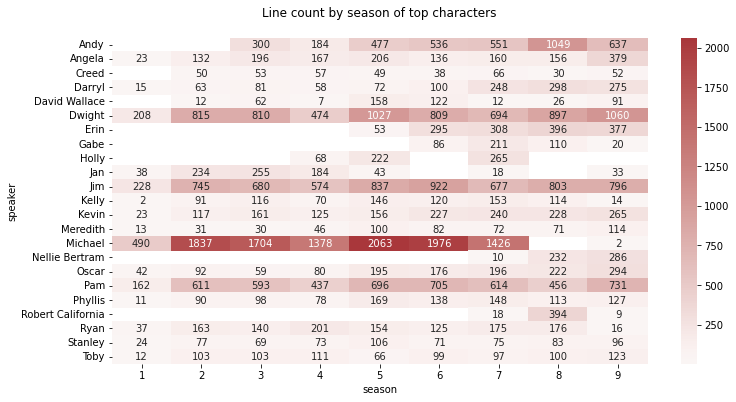

In [21]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(line_count_by_season.set_index('speaker').replace(0, np.nan), 
            ax = ax, cmap = 'vlag', annot = True, fmt = '2g', center = 0)
plt.title('Line count by season of top characters\n')
plt.yticks(va = 'center', rotation = 0)
plt.show()

In [22]:
fig = px.bar(line_count_data.sort_values('median_lines_by_season'), 'median_lines_by_season', 'speaker',
              title = 'Average line count of top characters in their active seasons', 
              labels = {'speaker' : '', 'median_lines_by_season' : 'Median line number per season'},
              width = 750, height = 450)
fig.update_yaxes(tickfont = {'size' : 8})
fig.show()

In [23]:
fig = px.bar(line_count_by_season_all.sort_values(['season', 'lines']), 'lines', 'speaker', facet_col='season', 
             facet_col_wrap=3, facet_row_spacing=.1, facet_col_spacing=.15,
              title = 'Top characters by line count in each season',
              labels = {'speaker' : ''}, width = 950, height = 605)
fig.update_xaxes(showticklabels = True, matches = None)
fig.update_yaxes(showticklabels=True, matches = None, tickfont = {'size' : 8})
#fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
fig.update_layout(showlegend = False)
fig.show()

#### From & To

In [24]:
from_to_counts.rename(columns = {'line_count' : 'weight'}, inplace = True)
from_to_counts_by_season.rename(columns = {'line_count' : 'weight'}, inplace = True)

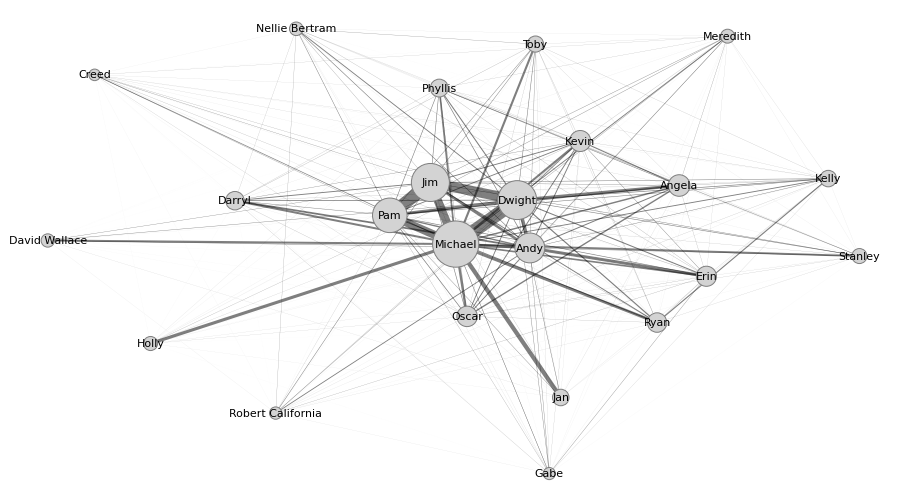

In [30]:
plot_conversation_network()


Season 1


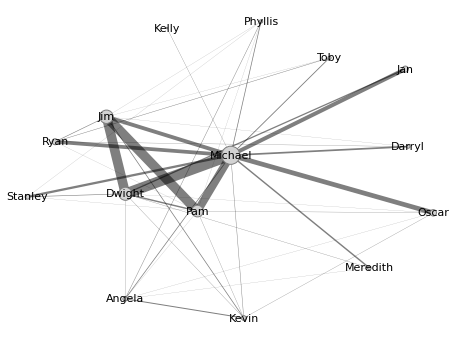


Season 2


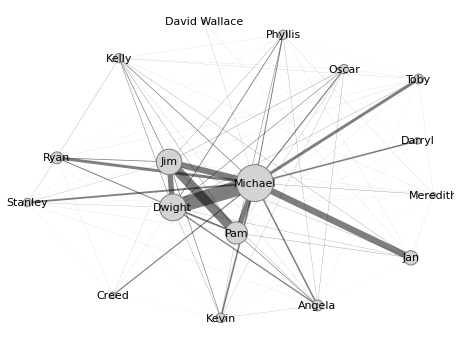


Season 3


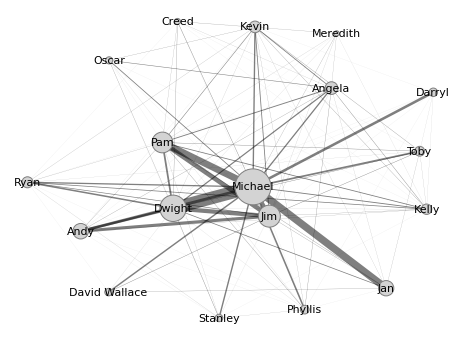


Season 4


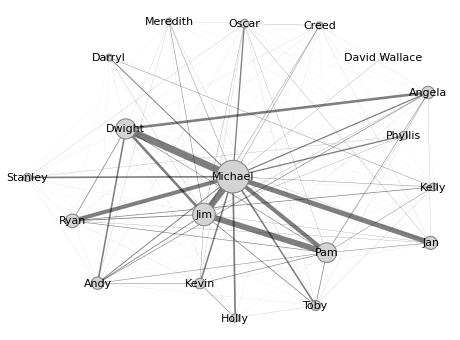


Season 5


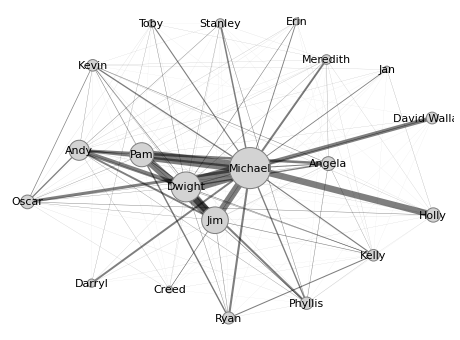


Season 6


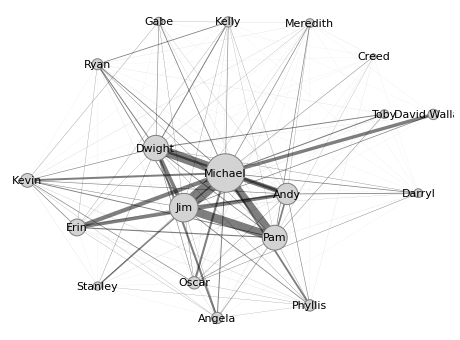


Season 7


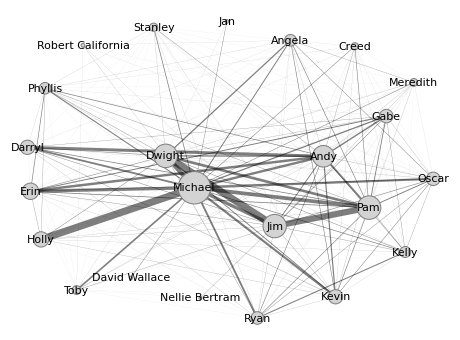


Season 8


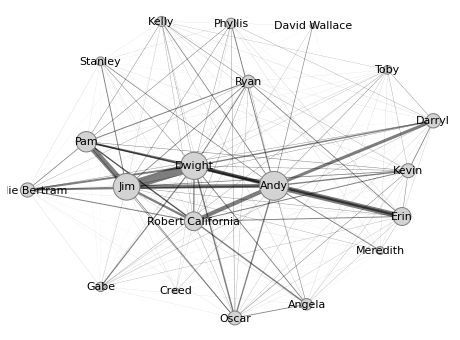


Season 9


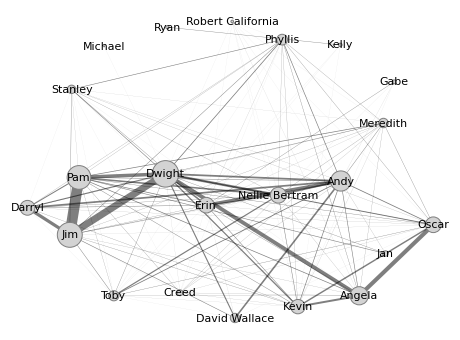

In [31]:
for season in np.arange(1, 9 + 1):
    
    from_to_data = from_to_counts_by_season[from_to_counts_by_season['season'] == season].reset_index(drop = True).drop('season', 1)
    print('\nSeason ' + str(season))
    
    if season == 1:
        plot_conversation_network(from_to_data, size = (8, 6), node_size_power = 1, edge_divider = 7, k = 6)
        
    else:
        plot_conversation_network(from_to_data, size = (8, 6), node_size_power = 1, edge_divider = 25, k = 8)

#### Word Count

In [32]:
ngram_plots()

In [33]:
ngram_plots(ngram_number=2, width = 1050, col_spacing=.15)

In [34]:
ngram_plots(ngram_number=3, row_spacing=.04, col_spacing=.2)

#### TF-IDF

In [117]:
tfidf_data_plot = tfidf_data.groupby('speaker').head(10)

In [118]:
plot_tfidf_data(tfidf_data_plot.sort_values(['speaker', 'score'], ascending = [True, True]))

#### WordClouds

Here I'm just showing people with 'meaningful' vocabularies, meaning checking the wordclouds we can guess the person who it belongs to

In [93]:
show_people = ['Angela', 'Oscar', 'Darryl', 'Phyllis', 'Stanley', 'David Wallace', 'Gabe', 'Robert California', 'Creed']

In [94]:
drop_words = [i.lower() for i in top_characters]
drop_words.extend(['well', 'right', 'good', 'thing', 'nellie', 'bertram', 'robert', 'california', 'yeah', 'say', 'really', 'need', 'guy', 'something'])
mask_dict = {'Michael' : 'fas fa-coffee', 'Dwight' : 'fas fa-tractor', 'Jim' : 'fas fa-child', 'Pam' : 'fas fa-paint-brush', 'Andy' : 'fas fa-music', 'Angela' : 'fas fa-cat', 'Kevin' : 'fas fa-birthday-cake', 'Erin' : 'fas fa-pen', 'Oscar' : 'fas fa-user-tie', 'Darryl' : 'fas fa-truck-loading', 'Ryan' : 'fas fa-book', 'Phyllis' : 'fas fa-mitten', 'Kelly' : 'fas fa-circle', 'Toby' : 'fas fa-circle', 'Jan' : 'fas fa-circle', 'Stanley' : 'fas fa-hat-cowboy', 'Meredith' : 'fas fa-wine-glass', 'Holly' : 'fas fa-circle', 'Nellie Bertram' : 'fas fa-circle', 'David Wallace' : 'fas fa-money-bill-alt', 'Gabe' : 'fas fa-circle', 'Robert California' : 'fas fa-circle',  'Creed' : 'fas fa-circle'}



Angela


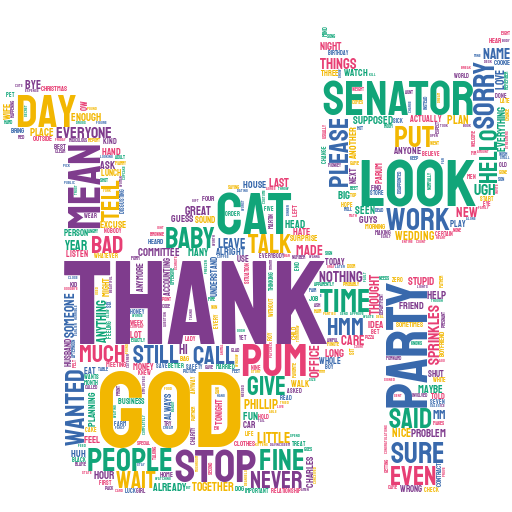



Oscar


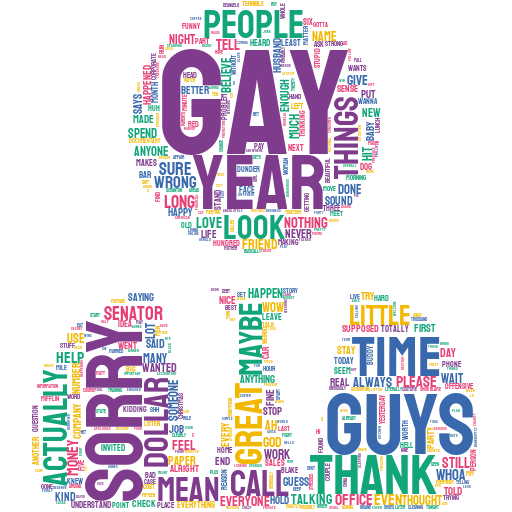



Darryl


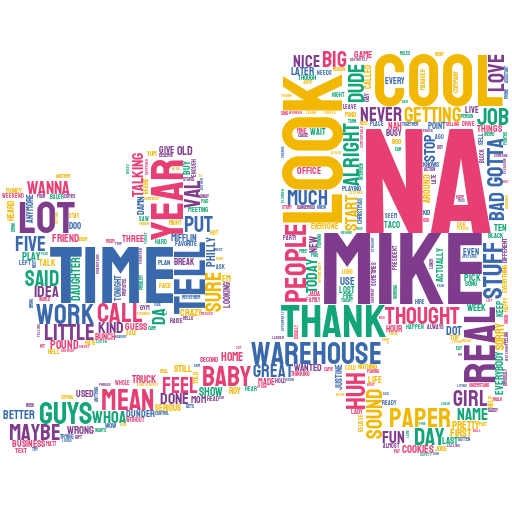



Phyllis


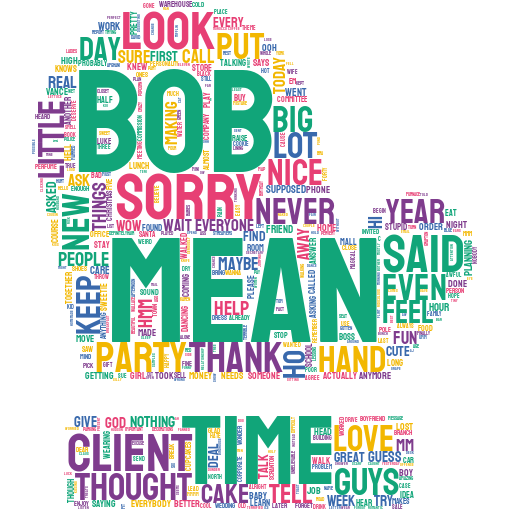



Stanley


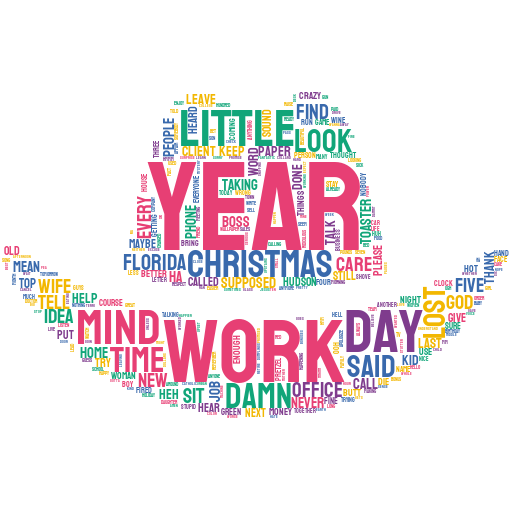



David Wallace


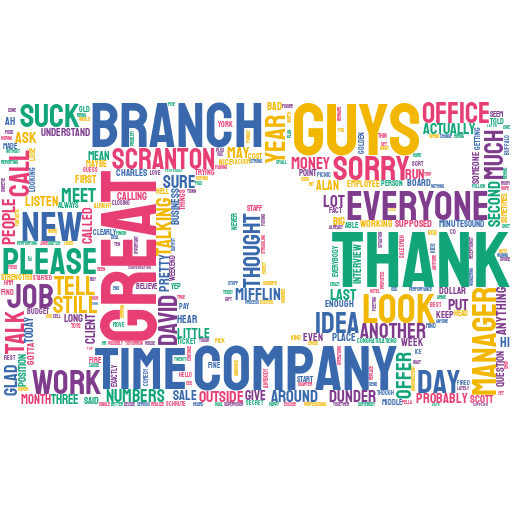



Gabe


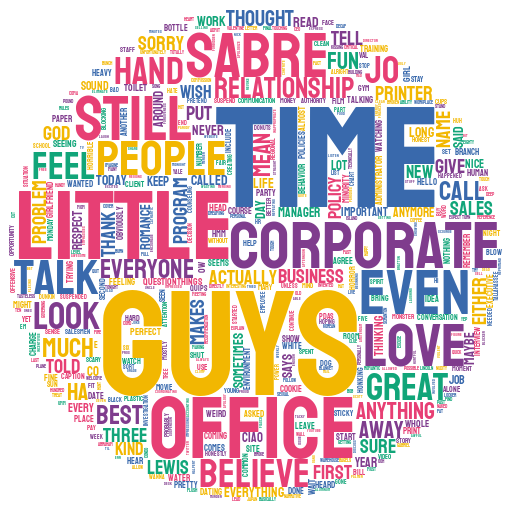



Robert California


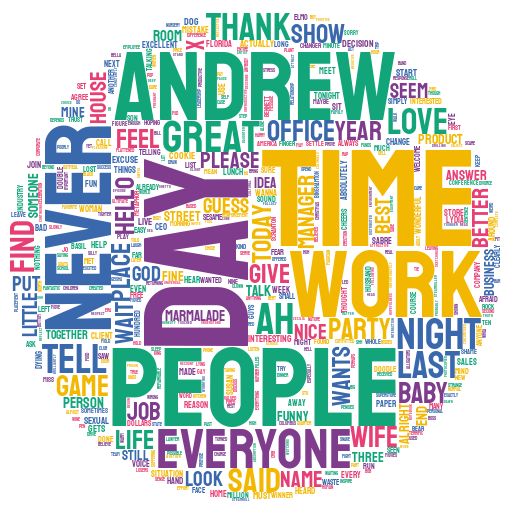



Creed


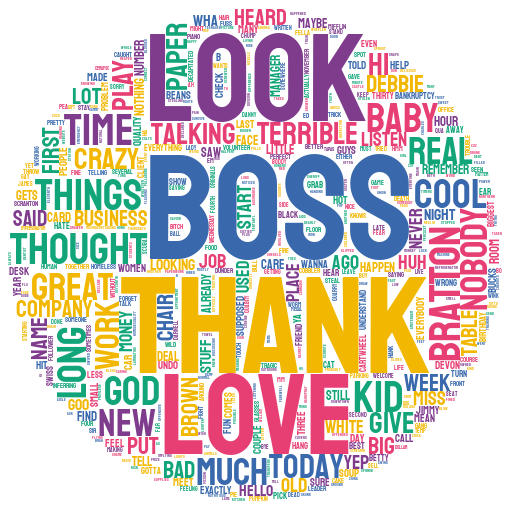

In [130]:
for speaker in top_characters:
    
    mask = mask_dict[speaker]
    
    wc_data = re.compile('\s+').sub(' ', ' '.join(lines[lines['speaker'] == speaker]['cleaned_sw_rem']))
    wc_data = ' '.join([word for word in wc_data.split() if word not in drop_words])
    
    stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 150, icon_name = mask,
                              output_name = 'wordclouds/' + speaker + '.png', collocations = False)
    
    if speaker in show_people:
        print('\n\n' + speaker)
        display(Image(filename = 'wordclouds/' + speaker + '.png', width = 450))

WordClouds from TF-IDFs?

In [122]:
tfidf_wc = tfidf_data.copy()
tfidf_wc['score'] = round(tfidf_wc['score'], 0).astype(int)
tfidf_wc['line'] = tfidf_wc.apply(lambda x: ''.join((x['word'] + ' ') * x['score']), 1)
tfidf_wc = tfidf_wc[tfidf_wc['line'] != '']

tfidf_wc.drop(['word', 'score'],1, inplace = True)



TF-IDF for Angela


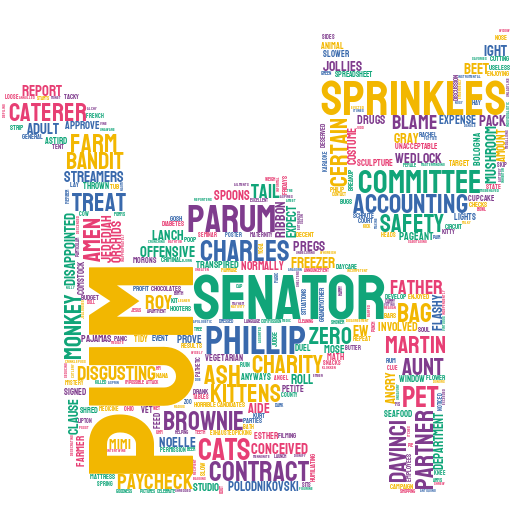



TF-IDF for Oscar


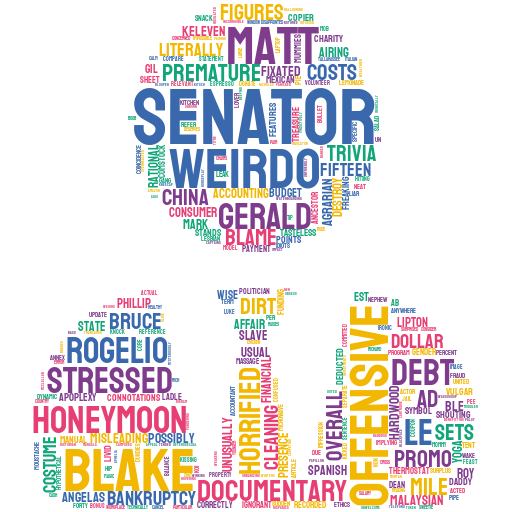



TF-IDF for Darryl


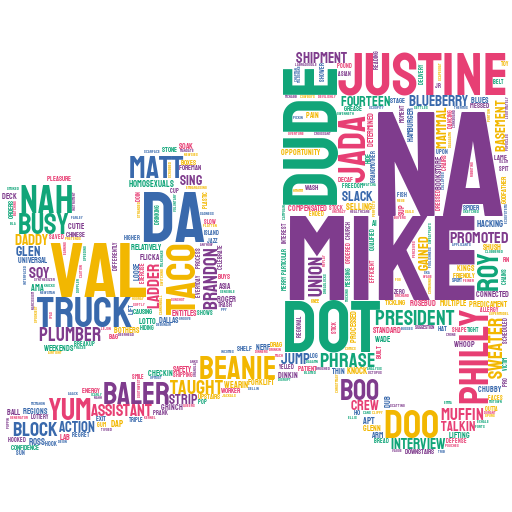



TF-IDF for Phyllis


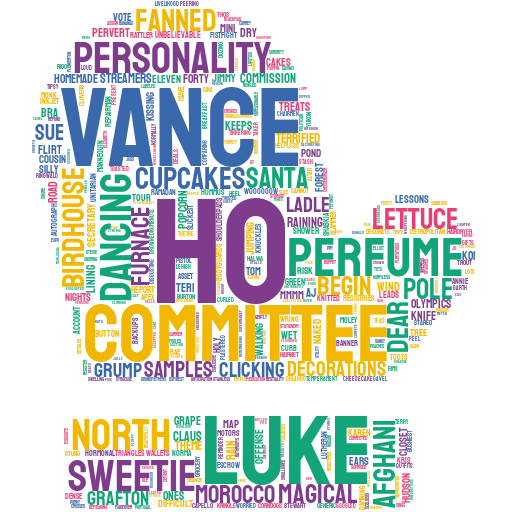



TF-IDF for Stanley


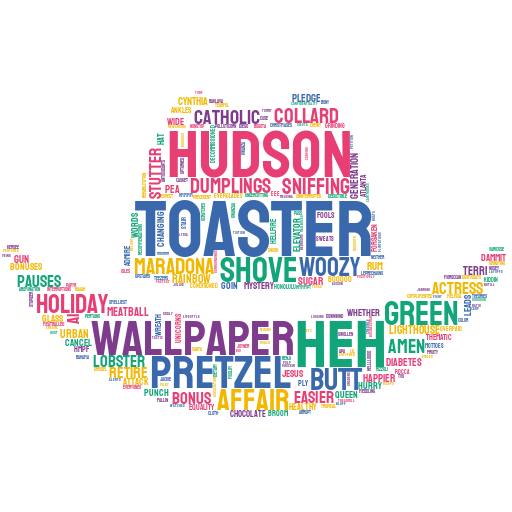



TF-IDF for David Wallace


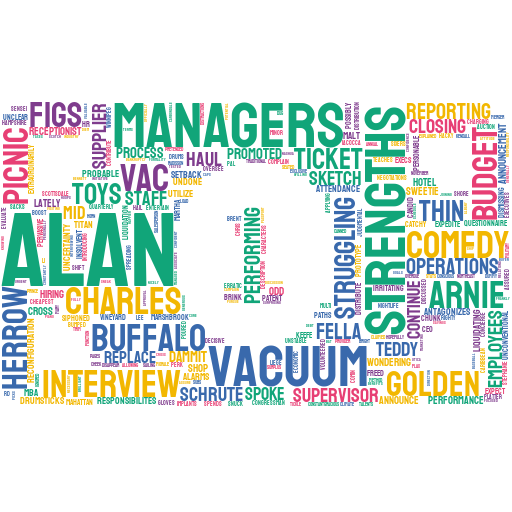



TF-IDF for Gabe


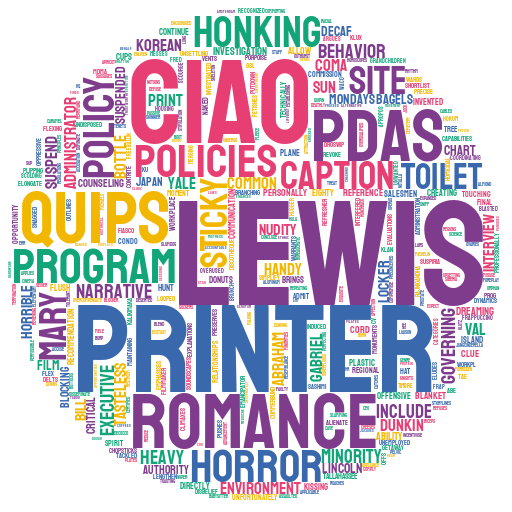



TF-IDF for Robert California


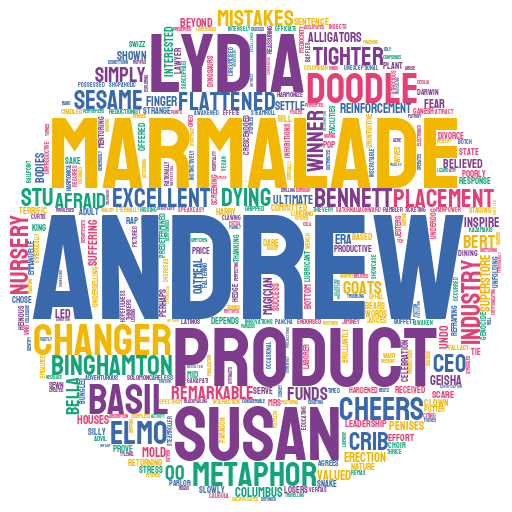



TF-IDF for Creed


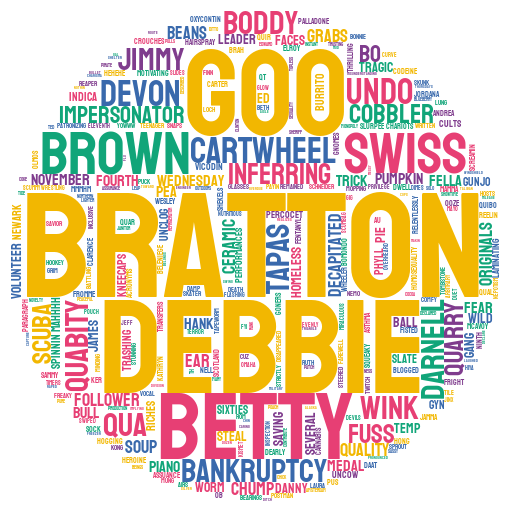

In [129]:
for speaker in top_characters:
    
    mask = mask_dict[speaker]
    
    wc_data = re.compile('\s+').sub(' ', ' '.join(tfidf_wc[tfidf_wc['speaker'] == speaker]['line'])).strip()    
    stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 150, icon_name = mask,
                              output_name = 'wordclouds/' + speaker + '_TF-IDF.png', collocations = False)
    
    if speaker in show_people:
        print('\n\nTF-IDF for ' + speaker)
        display(Image(filename = 'wordclouds/' + speaker + '_TF-IDF.png', width = 450))

#### TF-IDF vs simple unigram wordclouds: TF-IDF better 'describe' a person, as these words are more 'personal' - great NLP tool!

In [ ]:
# net = Network(notebook = True)
# net.from_nx(G)

# net.height = '450px'
# net.width = '850px'
# net.show('The Office - conversation network for top characters.html')

In [26]:
# ### ngrams other way around

# documents = lines['speaker'].unique().tolist()
# grams_dfs_speaker = {}
# Ns = [1, 2, 3]

# for speaker in documents:
    
#     transcript = re.compile('\s+').sub(' ', ' '.join(lines[lines['speaker'] == speaker]['cleaned_sw_rem']))
#     grams_dfs = {}
    
#     for N in Ns:
    
#         ngram_col_name = 'ngram_' + str(N)
        
#         count_grams = Counter(ngrams(transcript.split(' '), N))
#         count_grams_df = pd.DataFrame.from_dict(count_grams, orient = 'index')\
#                                      .reset_index().sort_values(0, ascending = False).reset_index(drop = True)\
#                                      .rename(columns = {'index' : ngram_col_name, 0 : 'count'})
#         count_grams_df[ngram_col_name] = count_grams_df[ngram_col_name].apply(lambda x: ' '.join(x))
#         grams_dfs[N] = count_grams_df
        
#     grams_dfs_speaker[speaker] = grams_dfs